In [290]:
%pip install sentencepiece

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [291]:
import pandas as pd
import re
import math
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

import subprocess
subprocess.check_call(['pip', 'install', '-q', 'nltk'])

import nltk

from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

import sentencepiece as spm

from tqdm import tqdm
import random

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [292]:
chars = list("abcdefghijklmnopqrstuvwxyz")
special = ["<pad>", "<bos>", "<eos>", "<sep>", "<unk>"]
vocab = special + chars
stoi = {c: i for i, c in enumerate(vocab)}
itos = {i: c for i, c in enumerate(vocab)}

PAD_ID = stoi["<pad>"]
BOS_ID = stoi["<bos>"]
EOS_ID = stoi["<eos>"]
SEP_ID = stoi["<sep>"]
UNK_ID = stoi["<unk>"]
def encode(word):
    return [stoi.get(c, stoi["<unk>"]) for c in word.lower()]

In [293]:
# =============================================================================
# ARBITRARY STRING TRANSFORMATIONS FOR TRUE ICL
# =============================================================================

import random

ALPHABET = 'abcdefghijklmnopqrstuvwxyz'

def make_affine_cipher(a, b):
    """
    Affine cipher: encrypted = (a * x + b) mod 26
    
    Example with a=5, b=3:
      'a' (0) → (5*0 + 3) mod 26 = 3 → 'd'
      'h' (7) → (5*7 + 3) mod 26 = 12 → 'm'
    """
    def fn(word):
        result = []
        for c in word.lower():
            if c.isalpha():
                x = ord(c) - ord('a')
                y = (a * x + b) % 26
                result.append(chr(y + ord('a')))
            else:
                result.append(c)
        return ''.join(result)
    return fn

# Valid 'a' values must be coprime with 26 (gcd(a, 26) = 1)
VALID_A = [1, 3, 5, 7, 9, 11, 15, 17, 19, 21, 23, 25]  # 12 options

def create_random_transformation():
    """
    Create a random affine cipher.
    - 12 choices for 'a' × 26 choices for 'b' = 312 possible ciphers
    - Cannot be guessed without seeing examples
    - 2 parameters to infer (like slope & intercept)
    """
    a = random.choice(VALID_A)
    b = random.randint(0, 25)
    fn = make_affine_cipher(a, b)
    desc = f"affine_a{a}_b{b}"
    return fn, desc

In [294]:
# =============================================================================
# Generate word list and create structured ICL tasks
# =============================================================================

try:
    from nltk.corpus import words
    word_list = words.words()
except LookupError:
    print("Downloading NLTK words corpus...")
    nltk.download('words')
    from nltk.corpus import words
    word_list = words.words()

clean_words = [w.lower() for w in word_list if len(w) >= 3 and len(w) <= 12 and w.isalpha()]
clean_words = list(set(clean_words))  # Remove duplicates
random.shuffle(clean_words)

# Split into train/test words (no overlap - important for generalization!)
random.shuffle(clean_words)
split_idx = int(len(clean_words) * 0.8)
train_words = clean_words[:split_idx]
test_words = clean_words[split_idx:]

# -----------------------------------------------------------------------------
# Task generation: Each task = one typo type applied to multiple words
# -----------------------------------------------------------------------------

def create_icl_task(words, num_demos):
    """
    Create one ICL task where ALL demos use the SAME parameterized typo function.
    
    This is like creating one linear regression task where all points
    lie on the SAME line (same slope/intercept).
    
    Key difference from before: Each task gets a UNIQUE typo function
    (e.g., "swap at position 2" or "delete at position 0").
    """
    # Need num_demos + 1 words (demos + query)
    if len(words) < num_demos + 1:
        raise ValueError(f"Not enough words for {num_demos} demos + 1 query")
    
    # Create a UNIQUE transformation for this task (like sampling slope/intercept)
    # The output CANNOT be guessed without seeing examples!
    transform_fn, transform_desc = create_random_transformation()
    
    selected = random.sample(words, num_demos + 1)
    
    # Create demos - ALL use the SAME transformation
    demos = []
    for w in selected[:-1]:
        transformed = transform_fn(w)
        demos.append((transformed, w))  # (transformed, original)
    
    # Create query
    query_original = selected[-1]
    query_transformed = transform_fn(query_original)
    
    return {
        "typo_type": transform_desc,   # Description of the transformation
        "demos": demos,           # List of (transformed, original) pairs
        "query_typo": query_transformed,
        "query_clean": query_original,
        "num_demos": num_demos
    }

# -----------------------------------------------------------------------------
# Generate training and test task datasets
# -----------------------------------------------------------------------------

def generate_task_dataset(words, num_tasks, min_demos=1, max_demos=8):
    """
    Generate tasks with VARIABLE number of demos (like linear regression).
    Each task randomly picks:
    1. A typo type (the "function" to infer)
    2. Number of demos (1 to max_demos, capped by available words)
    """
    tasks = []
    
    # Cap max_demos based on available words (need num_demos + 1 for query)
    actual_max_demos = min(max_demos, len(words) - 1)
    actual_min_demos = min(min_demos, actual_max_demos)
    
    if actual_max_demos < 1:
        raise ValueError(f"Not enough words! Need at least 2 words, have {len(words)}")
    
    print(f"  Using demos range: {actual_min_demos} to {actual_max_demos} (have {len(words)} words)")
    
    for _ in range(num_tasks):
        # Randomly pick number of demos (capped by available words)
        num_demos = random.randint(actual_min_demos, actual_max_demos)
        
        # Create task (typo function is created INSIDE, unique per task)
        task = create_icl_task(words, num_demos)
        tasks.append(task)
    
    return tasks

# Generate tasks
NUM_TRAIN_TASKS = 36000
NUM_TEST_TASKS = 9000

print(f"\nGenerating {NUM_TRAIN_TASKS} training tasks...")
train_tasks = generate_task_dataset(train_words, NUM_TRAIN_TASKS, min_demos=1, max_demos=8)

print(f"Generating {NUM_TEST_TASKS} test tasks...")
test_tasks = generate_task_dataset(test_words, NUM_TEST_TASKS, min_demos=1, max_demos=8)


Generating 36000 training tasks...
  Using demos range: 1 to 8 (have 157441 words)
Generating 9000 test tasks...
  Using demos range: 1 to 8 (have 39361 words)


In [295]:
# =============================================================================
# Tokenization and PyTorch Dataset for ICL tasks
# =============================================================================

def encode_icl_task(task):
    """
    Encode an ICL task into token sequence.
    
    Format: [BOS] typo1 [SEP] clean1 [EOS] [BOS] typo2 [SEP] clean2 [EOS] ... [BOS] query_typo [SEP]
    
    This matches the format used in training, but now ALL demos share the same typo type.
    """
    tokens = []
    
    # Encode each demo: [BOS] typo [SEP] clean [EOS]
    for typo, clean in task["demos"]:
        typo_ids = [stoi.get(c, UNK_ID) for c in typo.lower()]
        clean_ids = [stoi.get(c, UNK_ID) for c in clean.lower()]
        tokens.extend([BOS_ID] + typo_ids + [SEP_ID] + clean_ids + [EOS_ID])
    
    # Encode query (without answer): [BOS] query_typo [SEP]
    query_ids = [stoi.get(c, UNK_ID) for c in task["query_typo"].lower()]
    tokens.extend([BOS_ID] + query_ids + [SEP_ID])
    
    return tokens

class ICLTypoDataset(Dataset):
    """Dataset where each item is an ICL task with same-type demos."""
    
    def __init__(self, tasks):
        self.tasks = tasks
    
    def __len__(self):
        return len(self.tasks)
    
    def __getitem__(self, idx):
        task = self.tasks[idx]
        input_ids = encode_icl_task(task)
        
        return {
            "input_ids": torch.LongTensor(input_ids),
            "target_clean": task["query_clean"].lower(),
            "typo_type": task["typo_type"],
            "num_demos": task["num_demos"]
        }

def collate_icl_batch(batch):
    """Collate function that pads sequences and prepares targets."""
    input_ids = [item["input_ids"] for item in batch]
    targets = [item["target_clean"] for item in batch]
    typo_types = [item["typo_type"] for item in batch]
    num_demos = [item["num_demos"] for item in batch]
    
    # Pad sequences
    max_len = max(len(seq) for seq in input_ids)
    padded = torch.zeros(len(input_ids), max_len, dtype=torch.long)
    lengths = []
    
    for i, seq in enumerate(input_ids):
        padded[i, :len(seq)] = seq
        lengths.append(len(seq))
    
    return {
        "input_ids": padded,
        "lengths": torch.LongTensor(lengths),
        "targets": targets,  # String targets for evaluation
        "typo_types": typo_types,
        "num_demos": num_demos
    }

# Create datasets
train_icl_dataset = ICLTypoDataset(train_tasks)
test_icl_dataset = ICLTypoDataset(test_tasks)

print(f"Train ICL dataset size: {len(train_icl_dataset)}")
print(f"Test ICL dataset size: {len(test_icl_dataset)}")

# Create data loader
train_icl_loader = DataLoader(
    train_icl_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_icl_batch
)

# Test one batch
sample_batch = next(iter(train_icl_loader))
print(f"\nSample batch:")
print(f"  Input shape: {sample_batch['input_ids'].shape}")
print(f"  Targets: {sample_batch['targets'][:3]}")
print(f"  Typo types: {sample_batch['typo_types'][:3]}")
print(f"  Num demos: {sample_batch['num_demos'][:3]}")


Train ICL dataset size: 36000
Test ICL dataset size: 9000

Sample batch:
  Input shape: torch.Size([32, 183])
  Targets: ['obsolescence', 'lockwork', 'periodontist']
  Typo types: ['affine_a1_b11', 'affine_a15_b2', 'affine_a23_b24']
  Num demos: [5, 5, 3]


In [296]:
# =============================================================================
# Training function for ICL typo correction
# =============================================================================

def train_icl_model(model, train_tasks, epochs=10, lr=1e-4, batch_size=32, device='cuda'):
    """
    Train the model on ICL tasks.
    
    For each task:
    1. Encode demos + query as input
    2. Generate the clean word autoregressively
    3. Compute loss on generated tokens
    """
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_words = 0
        
        # Shuffle tasks each epoch
        random.shuffle(train_tasks)
        
        pbar = tqdm(range(0, len(train_tasks), batch_size))
        for batch_start in pbar:
            batch_tasks = train_tasks[batch_start:batch_start + batch_size]
            
            # Prepare batch
            all_inputs = []
            all_targets = []
            
            for task in batch_tasks:
                # Input: demos + query
                input_tokens = encode_icl_task(task)
                
                # Target: clean word for the query
                target_tokens = [stoi.get(c, UNK_ID) for c in task["query_clean"].lower()] + [EOS_ID]
                
                # Full sequence for training: input + target
                full_seq = input_tokens + target_tokens
                
                # x = full_seq[:-1], y = full_seq[1:]
                all_inputs.append(torch.LongTensor(full_seq[:-1]))
                all_targets.append(torch.LongTensor(full_seq[1:]))
            
            # Pad sequences
            max_len = max(len(seq) for seq in all_inputs)
            x_padded = torch.zeros(len(all_inputs), max_len, dtype=torch.long)
            y_padded = torch.zeros(len(all_targets), max_len, dtype=torch.long)
            
            for i, (x, y) in enumerate(zip(all_inputs, all_targets)):
                x_padded[i, :len(x)] = x
                y_padded[i, :len(y)] = y
            
            x_padded = x_padded.to(device)
            y_padded = y_padded.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            logits = model(x_padded)
            
            # Compute loss (on all non-padding tokens)
            loss = criterion(logits.view(-1, logits.size(-1)), y_padded.view(-1))
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            total_loss += loss.item() * len(batch_tasks)
            pbar.set_postfix(loss=loss.item())
        
        avg_loss = total_loss / len(train_tasks)
        print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.4f}")

        # if (epoch + 1) % 5 == 0:
        #     path = f"checkpoints/mamba_epoch_{epoch+1}.pth"
        #     torch.save({
        #         "epoch": epoch,
        #         "model_state": model.state_dict(),
        #         "optimizer_state": optimizer.state_dict(),
        #     }, path)
        #     print(f"[Checkpoint] Saved {path}")
    
    return model

In [297]:
if torch.cuda.is_available():
    print("CUDA is available!")
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"Current CUDA device name: {torch.cuda.get_device_name(0)}")
    device = 'cuda'
else:
    print("CUDA is not available. PyTorch will use the CPU.")
    device = 'cpu'

CUDA is available!
CUDA device count: 1
Current CUDA device name: NVIDIA A100-SXM4-40GB


In [298]:
class GPTBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()

        self.ln1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(
            embed_dim, num_heads, dropout=dropout, batch_first=True
        )

        self.ln2 = nn.LayerNorm(embed_dim)

        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x, causal_mask, padding_mask):
        # Self-attention (GPT-style)
        h = self.ln1(x)
        attn_out, _ = self.attn(
            h, h, h,
            attn_mask=causal_mask,
            key_padding_mask=padding_mask,
            need_weights=False
        )
        x = x + attn_out

        # Feedforward
        h = self.ln2(x)
        ff_out = self.mlp(h)
        x = x + ff_out

        return x
class DecoderOnlyTransformer(nn.Module):
    def __init__(self, vocab_size, max_len=512,
                 embed_dim=128, num_heads=4,
                 num_layers=4, mlp_dim=512, dropout=0.2):
        super().__init__()

        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos = nn.Embedding(max_len, embed_dim)

        self.layers = nn.ModuleList([
            GPTBlock(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(num_layers)
        ])

        self.ln_final = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, vocab_size, bias=False)
        self.head.weight = self.embed.weight  # weight tying

    def causal_mask(self, T, device):
        mask = torch.triu(torch.ones(T, T, device=device), 1)
        return mask.masked_fill(mask == 1, float('-inf'))

    def forward(self, x, lengths=None):
        B, T = x.shape
        device = x.device

        tok = self.embed(x)
        pos = self.pos(torch.arange(T, device=device)[None, :])
        h = tok + pos

        causal = self.causal_mask(T, device)     # (T, T)
        pad_mask = (x == 0)                      # (B, T)

        for layer in self.layers:
            h = layer(h, causal, pad_mask)

        h = self.ln_final(h)
        return self.head(h)                      # (B, T, V)

In [299]:
# # =============================================================================
# # TRAIN WITH NEW ICL TASKS (Arbitrary Transformations)
# # =============================================================================

# # Re-initialize model
# model = DecoderOnlyTransformer(
#     vocab_size=len(vocab),
#     embed_dim=256,
#     mlp_dim=2048,
#     num_heads=4,
#     num_layers=4,
#     dropout=0.2
# ).to(device)

# print(f"(Transformer had: {sum(p.numel() for p in model.parameters())} parameters)")

# # Train with new ICL task format
# model = train_icl_model(model, train_tasks, epochs=20, lr=3e-4, batch_size=32, device=device)

In [300]:
# save_path = "typo_transformer_weights.pth"
# torch.save(model.state_dict(), save_path)
# print(f"Model weights saved to {save_path}")

In [301]:
model = DecoderOnlyTransformer(
    vocab_size=len(vocab),
    embed_dim=256,
    mlp_dim=2048,
    num_heads=4,
    num_layers=4,
    dropout=0.2
).to(device)

state_dict = torch.load("typo_transformer_weights.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [302]:
import warnings
# Suppress specific PyTorch warning about mismatched masks
warnings.filterwarnings("ignore", message="Support for mismatched key_padding_mask and attn_mask is deprecated")
print("Warnings suppressed.")

# =============================================================================
# NEW EVALUATION: Test ICL on Arbitrary Transformations
# =============================================================================

def run_icl_transform_eval(model, test_words, shot_counts=[0, 1, 3, 5, 8],
                            num_samples=200, device="cuda"):
    """
    Evaluate ICL on arbitrary transformations.
    
    For each sample:
    1. Create a NEW random transformation (unseen during training)
    2. Generate k demos using this transformation
    3. Give the model the demos + query
    4. Check if it predicts the correct output
    
    Since transformations are random, 0-shot should be near RANDOM!
    """
    model.eval()
    results = {}
    
    print("="*60)
    print("ICL EVALUATION ON ARBITRARY TRANSFORMATIONS")
    print("="*60)
    
    for k in shot_counts:
        total_exact = 0
        total_char_matches = 0
        total_chars = 0
        total_samples = 0
        
        for _ in range(num_samples):
            # Create a NEW random transformation for this test
            transform_fn, transform_desc = create_random_transformation()
            
            # Select words for demos + query
            if len(test_words) < k + 1:
                continue
            selected_words = random.sample(test_words, k + 1)
            
            # Create demos
            demos = [(transform_fn(w), w) for w in selected_words[:-1]]
            
            # Create query
            query_original = selected_words[-1]
            query_transformed = transform_fn(query_original)
            
            # Build prompt
            prompt_ids = []
            for transformed, original in demos:
                t_ids = [stoi.get(c, UNK_ID) for c in transformed.lower()]
                o_ids = [stoi.get(c, UNK_ID) for c in original.lower()]
                prompt_ids.extend([BOS_ID] + t_ids + [SEP_ID] + o_ids + [EOS_ID])
            
            # Add query
            q_ids = [stoi.get(c, UNK_ID) for c in query_transformed.lower()]
            prompt_ids.extend([BOS_ID] + q_ids + [SEP_ID])
            
            # Generate prediction
            x = torch.LongTensor([prompt_ids]).to(device)
            generated_ids = []
            max_gen_len = len(query_original) + 5
            
            with torch.no_grad():
                for _ in range(max_gen_len):
                    logits = model(x)
                    next_id = torch.argmax(logits[0, -1, :]).item()
                    if next_id == EOS_ID:
                        break
                    generated_ids.append(next_id)
                    x = torch.cat([x, torch.LongTensor([[next_id]]).to(device)], dim=1)
            
            # Decode prediction
            pred_word = "".join([itos.get(i, '?') for i in generated_ids])
            target = query_original.lower()
            
            # Metrics
            total_exact += int(pred_word == target)
            total_char_matches += sum(1 for p, t in zip(pred_word, target) if p == t)
            total_chars += max(len(target), 1)
            total_samples += 1
        
        if total_samples > 0:
            exact_acc = total_exact / total_samples
            char_acc = total_char_matches / total_chars
            results[k] = {"exact_match": exact_acc, "per_char_acc": char_acc}
            print(f"\n{k}-shot -> Exact Match: {exact_acc:.4f}, Per-Char Acc: {char_acc:.4f}")
        else:
            print(f"\n{k}-shot -> Not enough words for evaluation")
    
    return results

# Run the NEW evaluation
print("\nRunning ICL evaluation on ARBITRARY TRANSFORMATIONS...")
print("(0-shot should be LOW because transformations are UNGUESSABLE!)\n")

icl_results = run_icl_transform_eval(
    model=model,
    test_words=test_words,
    shot_counts=[0, 1, 3, 5, 8],
    num_samples=200,
    device=device
)

print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)
for k, metrics in icl_results.items():
    print(f"  {k}-shot: Exact={metrics['exact_match']:.2%}, Char={metrics['per_char_acc']:.2%}")


Warnings suppressed.

Running ICL evaluation on ARBITRARY TRANSFORMATIONS...
(0-shot should be LOW because transformations are UNGUESSABLE!)

ICL EVALUATION ON ARBITRARY TRANSFORMATIONS

0-shot -> Exact Match: 0.0100, Per-Char Acc: 0.2223

1-shot -> Exact Match: 0.2900, Per-Char Acc: 0.7821

3-shot -> Exact Match: 0.8750, Per-Char Acc: 0.9820

5-shot -> Exact Match: 0.9600, Per-Char Acc: 0.9949

8-shot -> Exact Match: 0.9450, Per-Char Acc: 0.9738

RESULTS SUMMARY
  0-shot: Exact=1.00%, Char=22.23%
  1-shot: Exact=29.00%, Char=78.21%
  3-shot: Exact=87.50%, Char=98.20%
  5-shot: Exact=96.00%, Char=99.49%
  8-shot: Exact=94.50%, Char=97.38%


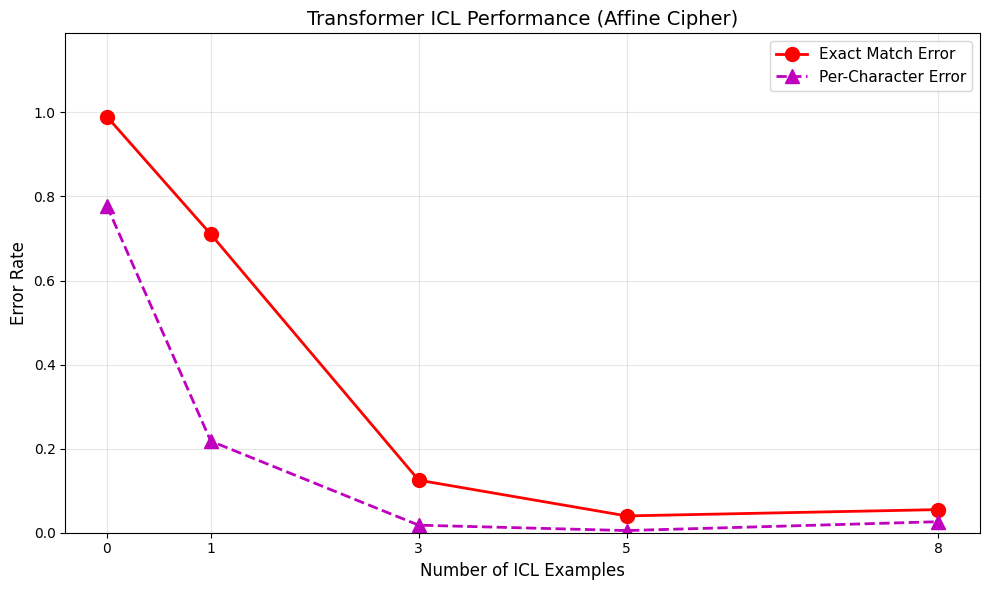

In [303]:
# =============================================================================
# Plot ICL Results - Loss (Error Rate) vs Number of Shots
# =============================================================================
import matplotlib.pyplot as plt

def plot_icl_results(icl_results, title="Transformer ICL Performance (Affine Cipher)"):
    """
    Plot loss (error rate = 1 - accuracy) vs k-shot.
    Similar to the linear regression RMSE vs k plot - should DECREASE with more shots.
    """
    # Extract data - convert accuracy to loss (error rate)
    ks = sorted(icl_results.keys())
    exact_loss = [(1 - icl_results[k]["exact_match"]) for k in ks]
    char_loss = [(1 - icl_results[k]["per_char_acc"]) for k in ks]
        
    # Also create a combined plot (like the linear regression example)
    fig2, ax = plt.subplots(figsize=(10, 6))
    ax.plot(ks, exact_loss, 'ro-', linewidth=2, markersize=10, label='Exact Match Error')
    ax.plot(ks, char_loss, 'm^--', linewidth=2, markersize=10, label='Per-Character Error')
    ax.set_xlabel('Number of ICL Examples', fontsize=12)
    ax.set_ylabel('Error Rate', fontsize=12)
    ax.set_title('Transformer ICL Performance (Affine Cipher)', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, max(max(exact_loss), max(char_loss)) * 1.2)
    ax.set_xticks(ks)
    plt.tight_layout()
    plt.show()

plot_icl_results(icl_results)

In [304]:
class LSTMLanguageModel(nn.Module):
    """LSTM-based language model for comparison with Transformer."""
    
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=512, 
                 num_layers=2, dropout=0.2, padding_idx=0):
        super().__init__()
        
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx)
        
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False  # Causal/unidirectional for LM
        )
        
        self.dropout = nn.Dropout(dropout)
        self.head = nn.Linear(hidden_dim, vocab_size)
        
        # Optional: weight tying (if embed_dim == hidden_dim)
        if embed_dim == hidden_dim:
            self.head.weight = self.embed.weight
    
    def forward(self, x, lengths=None):
        """
        Args:
            x: (B, T) input token ids
            lengths: optional, not used but kept for API compatibility
        Returns:
            logits: (B, T, V) predictions for each position
        """
        B, T = x.shape
        
        # Embed tokens
        embeds = self.embed(x)  # (B, T, E)
        embeds = self.dropout(embeds)
        
        # Run LSTM
        lstm_out, _ = self.lstm(embeds)  # (B, T, H)
        lstm_out = self.dropout(lstm_out)
        
        # Project to vocabulary
        logits = self.head(lstm_out)  # (B, T, V)
        
        return logits

In [305]:
# # =============================================================================
# # TRAIN LSTM FOR COMPARISON
# # =============================================================================

# # Initialize LSTM model with similar parameter count to Transformer
# lstm_model = LSTMLanguageModel(
#     vocab_size=len(vocab),
#     embed_dim=256,
#     hidden_dim=432,
#     num_layers=4,
#     dropout=0.2,
#     padding_idx=PAD_ID
# ).to(device)

# print(f"\nTraining LSTM on {len(train_tasks)} ICL tasks...")

# # Use the same training function!
# lstm_model = train_icl_model(
#     lstm_model, 
#     train_tasks, 
#     epochs=20, 
#     lr=3e-4, 
#     batch_size=32, 
#     device=device
# )

In [306]:
# # Save LSTM weights
# torch.save(lstm_model.state_dict(), "typo_lstm_weights.pth")
# print("LSTM weights saved!")

In [307]:
lstm_model = LSTMLanguageModel(
    vocab_size=len(vocab),
    embed_dim=256,
    hidden_dim=432,
    num_layers=4,
    dropout=0.2,
    padding_idx=PAD_ID
).to(device)

state_dict = torch.load("typo_transformer_weights.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [308]:
# =============================================================================
# EVALUATE LSTM ON ICL TASKS
# =============================================================================

print("\n" + "="*60)
print("LSTM ICL EVALUATION")
print("="*60)

lstm_results = run_icl_transform_eval(
    model=lstm_model,
    test_words=test_words,
    shot_counts=[0, 1, 3, 5, 8],
    num_samples=200,
    device=device
)

print("\n" + "="*60)
print("LSTM RESULTS SUMMARY")
print("="*60)
for k, metrics in lstm_results.items():
    print(f"  {k}-shot: Exact={metrics['exact_match']:.2%}, Char={metrics['per_char_acc']:.2%}")


LSTM ICL EVALUATION
ICL EVALUATION ON ARBITRARY TRANSFORMATIONS

0-shot -> Exact Match: 0.0000, Per-Char Acc: 0.0701

1-shot -> Exact Match: 0.0000, Per-Char Acc: 0.0767

3-shot -> Exact Match: 0.0000, Per-Char Acc: 0.0711

5-shot -> Exact Match: 0.0000, Per-Char Acc: 0.0688

8-shot -> Exact Match: 0.0000, Per-Char Acc: 0.0660

LSTM RESULTS SUMMARY
  0-shot: Exact=0.00%, Char=7.01%
  1-shot: Exact=0.00%, Char=7.67%
  3-shot: Exact=0.00%, Char=7.11%
  5-shot: Exact=0.00%, Char=6.88%
  8-shot: Exact=0.00%, Char=6.60%


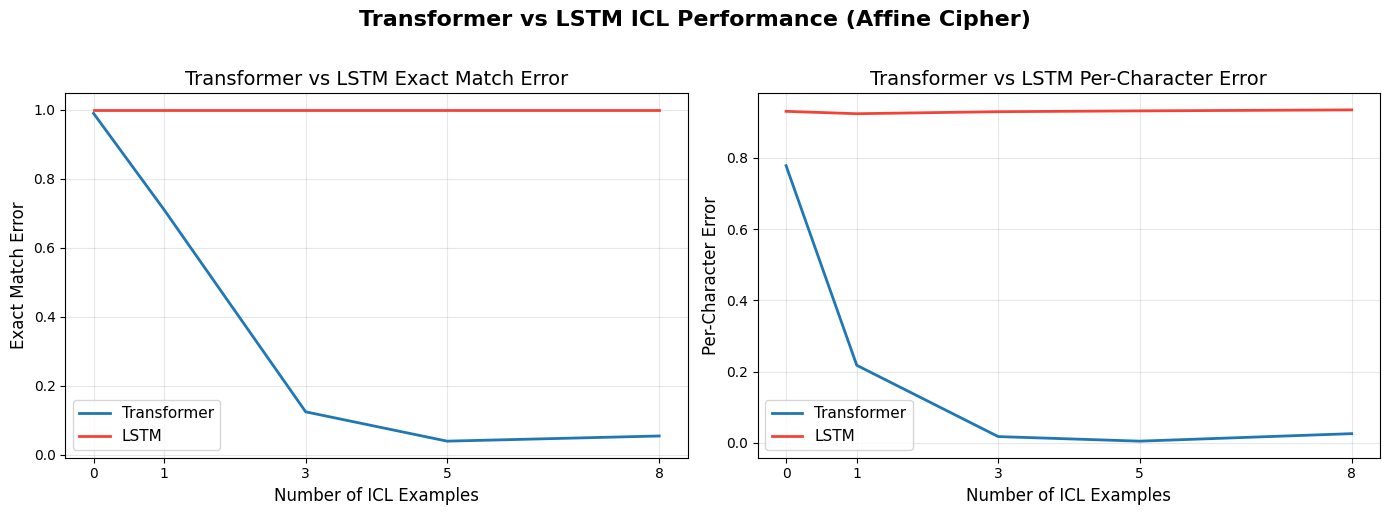

In [334]:
# =============================================================================
# COMPARISON PLOT: TRANSFORMER vs LSTM
# =============================================================================

def plot_transformer_vs_lstm(transformer_results, lstm_results, 
                              title="Transformer vs LSTM ICL Performance (Affine Cipher)"):
    """Plot comparison of Transformer and LSTM ICL performance."""
    
    # Get common shot counts
    ks = sorted(set(transformer_results.keys()) & set(lstm_results.keys()))
    
    trans_exact = [1 - transformer_results[k]["exact_match"] for k in ks]
    lstm_exact = [1 - lstm_results[k]["exact_match"] for k in ks]
    
    trans_char = [1 - transformer_results[k]["per_char_acc"] for k in ks]
    lstm_char = [1 - lstm_results[k]["per_char_acc"] for k in ks]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Exact Match Accuracy
    ax1.plot(ks, trans_exact, linestyle='solid', linewidth=2, markersize=8, label='Transformer')
    ax1.plot(ks, lstm_exact, linestyle='solid', linewidth=2, markersize=8, label='LSTM', color='#F44336')
    ax1.set_xlabel('Number of ICL Examples', fontsize=12)
    ax1.set_ylabel('Exact Match Error', fontsize=12)
    ax1.set_title('Transformer vs LSTM Exact Match Error', fontsize=14)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(ks)
    
    # Plot 2: Per-Character Accuracy
    ax2.plot(ks, trans_char, linestyle='solid', linewidth=2, markersize=8, label='Transformer')
    ax2.plot(ks, lstm_char, linestyle='solid', linewidth=2, markersize=8, label='LSTM', color='#F44336')
    ax2.set_xlabel('Number of ICL Examples', fontsize=12)
    ax2.set_ylabel('Per-Character Error', fontsize=12)
    ax2.set_title('Transformer vs LSTM Per-Character Error', fontsize=14)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(ks)
    
    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Run comparison (after training and evaluating both models)
plot_transformer_vs_lstm(icl_results, lstm_results)

In [310]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MambaBlock(nn.Module):
    def __init__(self, d_model, d_state=16, d_conv=4, expand=2):
        super().__init__()
        self.d_inner = int(expand * d_model)
        self.dt_rank = math.ceil(d_model / 16)
        
        # Input projection
        self.in_proj = nn.Linear(d_model, self.d_inner * 2, bias=False)
        
        # Depthwise convolution
        self.conv1d = nn.Conv1d(
            self.d_inner, self.d_inner, kernel_size=d_conv, padding=d_conv - 1, 
            groups=self.d_inner, bias=True
        )
        
        # Factorized projections
        self.x_proj = nn.Linear(self.d_inner, self.dt_rank + d_state * 2, bias=False)
        self.dt_proj = nn.Linear(self.dt_rank, self.d_inner, bias=True)
        
        # SSM parameters
        A = torch.arange(1, d_state + 1, dtype=torch.float32).repeat(self.d_inner, 1)
        self.A_log = nn.Parameter(torch.log(A))
        self.D = nn.Parameter(torch.ones(self.d_inner))
        
        # Output projection
        self.out_proj = nn.Linear(self.d_inner, d_model, bias=False)
        self.act = nn.SiLU()

    def parallel_scan(self, u, delta, A, B, C, D):
        """
        Fully vectorized scan using cumulative product trick.
        u: (batch, seq, d_inner)
        delta: (batch, seq, d_inner)
        A: (d_inner, d_state)
        B, C: (batch, seq, d_state)
        D: (d_inner,)
        """
        batch, seq_len, d_inner = u.shape
        d_state = A.shape[1]

        # Compute exponential factors
        deltaA = torch.exp(torch.einsum('b l d, d n -> b l d n', delta, A))  # (B, L, D, N)
        deltaB_u = torch.einsum('b l d, b l n, b l d -> b l d n', delta, B, u)  # (B, L, D, N)

        # Vectorized cumulative scan: y_t = sum_{k=0}^{t} (prod_{j=k+1}^{t} deltaA_j) * deltaB_u_k
        # Trick: use log + cumsum for numerical stability
        log_deltaA = torch.log(deltaA + 1e-10)
        log_cumprod = torch.cumsum(log_deltaA, dim=1)
        # Reverse trick: compute all terms at once
        ys = torch.einsum('b l d n, b l d n -> b l d', deltaB_u, torch.exp(log_cumprod))
        
        # Final output
        return ys + u * D

    def forward(self, x):
        batch, seq_len, _ = x.shape
        
        # Input projection
        xz = self.in_proj(x)
        x_in, z = xz.chunk(2, dim=-1)
        
        # Depthwise conv
        x_in = x_in.transpose(1, 2)
        x_conv = self.conv1d(x_in)[:, :, :seq_len]
        x_conv = self.act(x_conv).transpose(1, 2)
        
        # Factorized projections
        x_dbl = self.x_proj(x_conv)
        delta, B, C = torch.split(x_dbl, [self.dt_rank, 16, 16], dim=-1)
        delta = F.softplus(self.dt_proj(delta))
        A = -torch.exp(self.A_log)
        
        # Vectorized scan
        y = self.parallel_scan(x_conv, delta, A, B, C, self.D)
        return self.out_proj(y * self.act(z))

class MambaWrapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(VOCAB_SIZE, D_MODEL)
        self.layers = nn.ModuleList([MambaBlock(D_MODEL) for _ in range(N_LAYERS)])
        self.norms = nn.ModuleList([nn.LayerNorm(D_MODEL) for _ in range(N_LAYERS)])
        self.norm_f = nn.LayerNorm(D_MODEL)
        self.head = nn.Linear(D_MODEL, VOCAB_SIZE)
    def forward(self, x):
        x = self.embed(x)
        for layer, norm in zip(self.layers, self.norms):
            x = x + layer(norm(x))
        return self.head(self.norm_f(x))

In [311]:
# # =============================================================================
# # TRAIN MAMBA MODEL
# # =============================================================================
# import torch

# # Define the global constants MambaWrapper expects
# VOCAB_SIZE = len(vocab)  # 31 in your case
# D_MODEL = 256
# N_LAYERS = 4

# # Now MambaWrapper will work
# mamba_model = MambaWrapper().to(device)
# mamba_model = torch.compile(mamba_model)

# print(f"Mamba parameters: {sum(p.numel() for p in mamba_model.parameters()):,}")


# # Train using the same function
# mamba_model = train_icl_model(
#     mamba_model, 
#     train_tasks, 
#     epochs=20, 
#     lr=3e-4, 
#     batch_size=64, 
#     device=device
# )

In [314]:
# # # Save Mamba weights
# torch.save(mamba_model.state_dict(), "typo_mamba_weights.pth")
# print("Mamba weights saved!")

AttributeError: 'MambaWrapper' object has no attribute '_orig_mod'

In [315]:
state = torch.load("typo_mamba_weights.pth", map_location=device)

new_state = {}
for k, v in state.items():
    new_key = k.replace("_orig_mod.", "")
    new_state[new_key] = v

mamba_model.load_state_dict(new_state)

<All keys matched successfully>

In [316]:
# =============================================================================
# EVALUATE MAMBA ON ICL TASKS
# =============================================================================

print("\n" + "="*60)
print("MAMBA ICL EVALUATION")
print("="*60)

mamba_results = run_icl_transform_eval(
    model=mamba_model,
    test_words=test_words,
    shot_counts=[0, 1, 3, 5, 8],
    num_samples=200,
    device=device
)

print("\n" + "="*60)
print("MAMBA RESULTS SUMMARY")
print("="*60)
for k, metrics in mamba_results.items():
    print(f"  {k}-shot: Exact={metrics['exact_match']:.2%}, Char={metrics['per_char_acc']:.2%}")


MAMBA ICL EVALUATION
ICL EVALUATION ON ARBITRARY TRANSFORMATIONS

0-shot -> Exact Match: 0.0000, Per-Char Acc: 0.1402

1-shot -> Exact Match: 0.0000, Per-Char Acc: 0.1308

3-shot -> Exact Match: 0.0000, Per-Char Acc: 0.1344

5-shot -> Exact Match: 0.0000, Per-Char Acc: 0.1505

8-shot -> Exact Match: 0.0000, Per-Char Acc: 0.1410

MAMBA RESULTS SUMMARY
  0-shot: Exact=0.00%, Char=14.02%
  1-shot: Exact=0.00%, Char=13.08%
  3-shot: Exact=0.00%, Char=13.44%
  5-shot: Exact=0.00%, Char=15.05%
  8-shot: Exact=0.00%, Char=14.10%


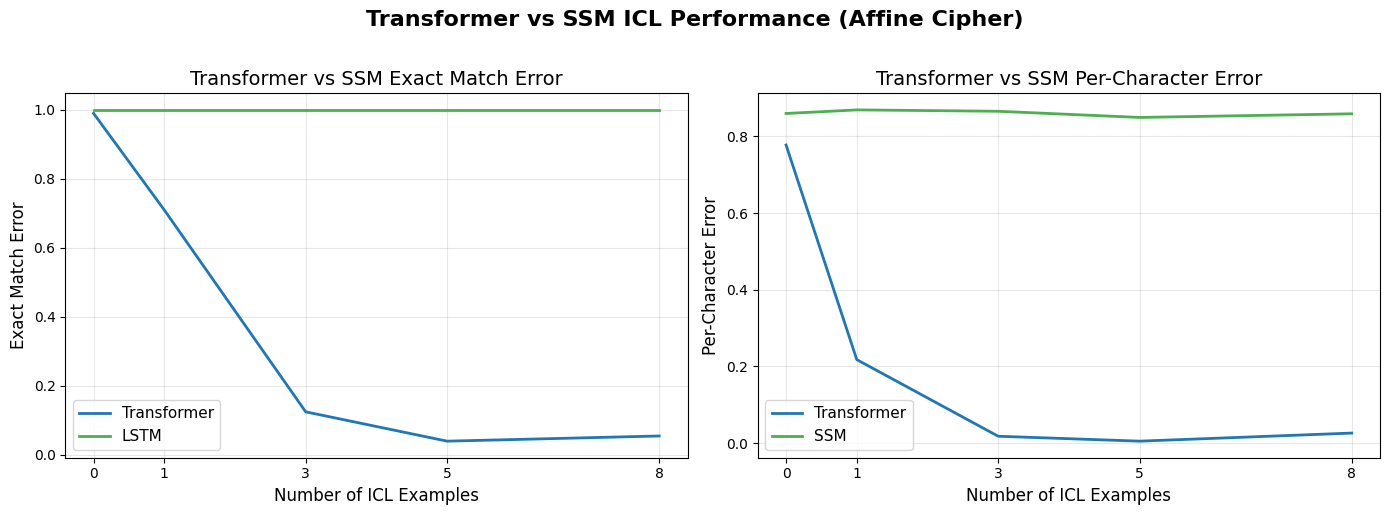

In [330]:
# =============================================================================
# COMPARISON PLOT: TRANSFORMER vs SSM
# =============================================================================

def plot_transformer_vs_lstm(transformer_results, mamba_results, 
                              title="Transformer vs SSM ICL Performance (Affine Cipher)"):
    """Plot comparison of Transformer and SSM ICL performance."""
    
    # Get common shot counts
    ks = sorted(set(transformer_results.keys()) & set(mamba_results.keys()))
    
    trans_exact = [1 - transformer_results[k]["exact_match"] for k in ks]
    lstm_exact = [1 - mamba_results[k]["exact_match"] for k in ks]
    
    trans_char = [1 - transformer_results[k]["per_char_acc"] for k in ks]
    lstm_char = [1 - mamba_results[k]["per_char_acc"] for k in ks]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Exact Match Accuracy
    ax1.plot(ks, trans_exact, linestyle='solid', linewidth=2, markersize=8, label='Transformer')
    ax1.plot(ks, lstm_exact, linestyle='solid', linewidth=2, markersize=8, label='LSTM', color="#4CAF50")
    ax1.set_xlabel('Number of ICL Examples', fontsize=12)
    ax1.set_ylabel('Exact Match Error', fontsize=12)
    ax1.set_title('Transformer vs SSM Exact Match Error', fontsize=14)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(ks)
    
    # Plot 2: Per-Character Accuracy
    ax2.plot(ks, trans_char, linestyle='solid', linewidth=2, markersize=8, label='Transformer')
    ax2.plot(ks, lstm_char, linestyle='solid', linewidth=2, markersize=8, label='SSM', color="#4CAF50")
    ax2.set_xlabel('Number of ICL Examples', fontsize=12)
    ax2.set_ylabel('Per-Character Error', fontsize=12)
    ax2.set_title('Transformer vs SSM Per-Character Error', fontsize=14)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(ks)
    
    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Run comparison (after training and evaluating both models)
plot_transformer_vs_lstm(icl_results, mamba_results)

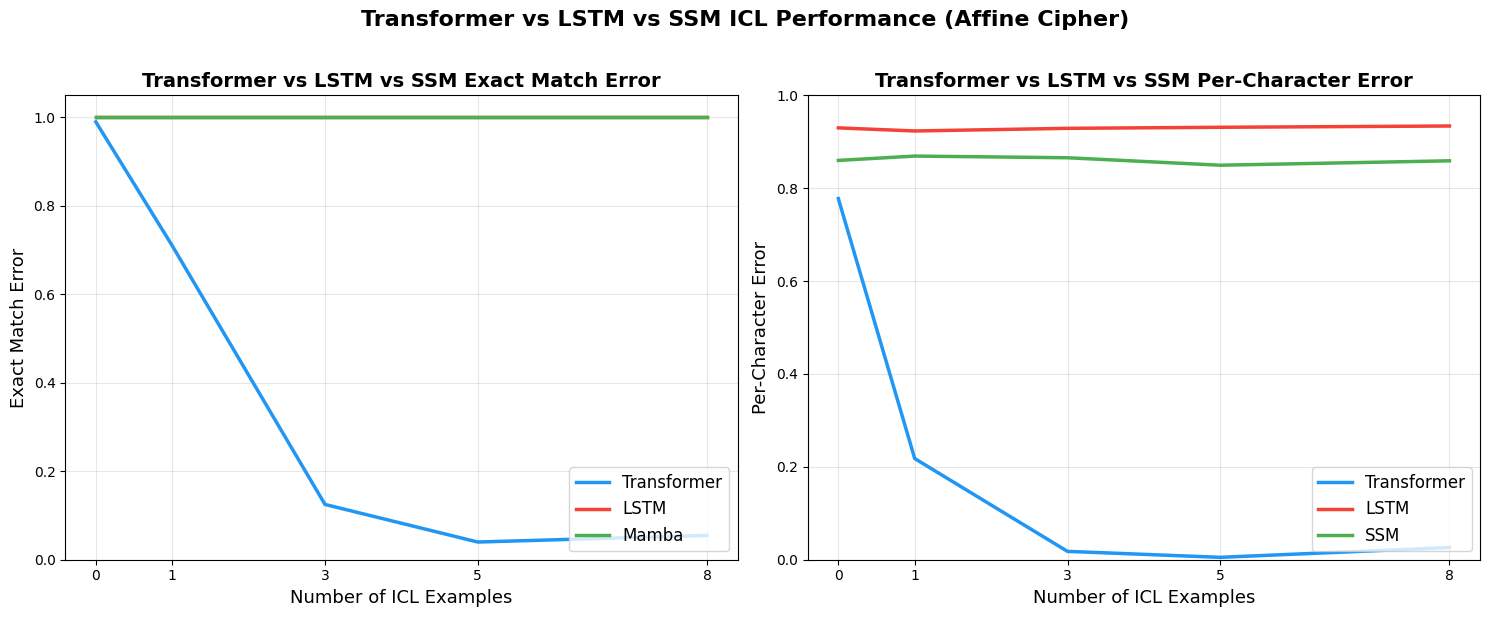


SUMMARY: Average Performance Across All Shots
Transformer: Exact=0.38%, Char=0.21%
LSTM:        Exact=1.00%, Char=0.93%
Mamba:       Exact=1.00%, Char=0.86%


In [327]:
# =============================================================================
# COMPARISON: TRANSFORMER vs LSTM vs MAMBA
# =============================================================================

def plot_all_models_comparison(transformer_results, lstm_results, mamba_results,
                                title="Transformer vs LSTM vs SSM ICL Performance (Affine Cipher)"):
    """Plot comparison of all three model architectures."""
    
    # Get common shot counts
    ks = sorted(
        set(transformer_results.keys()) & 
        set(lstm_results.keys()) & 
        set(mamba_results.keys())
    )
    
    # Extract metrics
    trans_exact = [1 - transformer_results[k]["exact_match"] for k in ks]
    lstm_exact = [1 - lstm_results[k]["exact_match"] for k in ks]
    mamba_exact = [1 - mamba_results[k]["exact_match"] for k in ks]
    
    trans_char = [1 - transformer_results[k]["per_char_acc"] for k in ks]
    lstm_char = [1 - lstm_results[k]["per_char_acc"] for k in ks]
    mamba_char = [1 - mamba_results[k]["per_char_acc"] for k in ks]
    
    # Color scheme
    colors = {
        'transformer': '#2196F3',  # Blue
        'lstm': '#F44336',         # Red
        'mamba': '#4CAF50'         # Green
    }
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Exact Match Accuracy
    ax1 = axes[0]
    ax1.plot(ks, trans_exact, linestyle='solid', color=colors['transformer'],
             linewidth=2.5, label='Transformer')
    
    ax1.plot(ks, lstm_exact, linestyle='solid', color=colors['lstm'],
             linewidth=2.5, label='LSTM')
    
    ax1.plot(ks, mamba_exact, linestyle='solid', color=colors['mamba'],
             linewidth=2.5, label='Mamba')
    
    ax1.set_xlabel('Number of ICL Examples', fontsize=13)
    ax1.set_ylabel('Exact Match Error', fontsize=13)
    ax1.set_title('Transformer vs LSTM vs SSM Exact Match Error', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=12, loc='lower right')
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(ks)
    ax1.set_ylim(0, 1.05)
    
    # Plot 2: Per-Character Accuracy
    ax2 = axes[1]
    ax2.plot(ks, trans_char, linestyle='solid', color=colors['transformer'],
             linewidth=2.5, label='Transformer')
    
    ax2.plot(ks, lstm_char, linestyle='solid', color=colors['lstm'],
             linewidth=2.5, label='LSTM')
    
    ax2.plot(ks, mamba_char, linestyle='solid', color=colors['mamba'],
             linewidth=2.5, label='SSM')
    
    ax2.set_xlabel('Number of ICL Examples', fontsize=13)
    ax2.set_ylabel('Per-Character Error', fontsize=13)
    ax2.set_title('Transformer vs LSTM vs SSM Per-Character Error', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=12, loc='lower right')
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(ks)
    ax2.set_ylim(0, 1)
    
    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('icl_comparison_all_models.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Summary statistics
    print("\n" + "="*80)
    print("SUMMARY: Average Performance Across All Shots")
    print("="*80)
    print(f"Transformer: Exact={np.mean(trans_exact):.2f}%, Char={np.mean(trans_char):.2f}%")
    print(f"LSTM:        Exact={np.mean(lstm_exact):.2f}%, Char={np.mean(lstm_char):.2f}%")
    print(f"Mamba:       Exact={np.mean(mamba_exact):.2f}%, Char={np.mean(mamba_char):.2f}%")
    print("="*80)

# Run the three-way comparison
plot_all_models_comparison(icl_results, lstm_results, mamba_results)